# Tarea Final: Embeddings & Transformers
##**Tópicos de IA** 
## ITESM Campus Guadalajara
## Escuela de Posgrados de Ingeniería y Ciencias##
## Maestría en Ciencias de la Computación
Elisa Fernández Castillo A01221781 Gabriel Briones Sayeg A01222517

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd drive/My Drive/DeepLearning2/Tarea Final/

/content/drive/My Drive/DeepLearning2/Tarea Final


In [ ]:
!wget https://huggingface.co/mrm8488/distill-bert-base-spanish-wwm-cased-finetuned-spa-squad2-es/resolve/main/pytorch_model.bin
!wget https://huggingface.co/mrm8488/distill-bert-base-spanish-wwm-cased-finetuned-spa-squad2-es/resolve/main/vocab.txt
!wget https://huggingface.co/mrm8488/distill-bert-base-spanish-wwm-cased-finetuned-spa-squad2-es/resolve/main/config.json

--2021-06-06 21:32:44--  https://huggingface.co/mrm8488/distill-bert-base-spanish-wwm-cased-finetuned-spa-squad2-es/resolve/main/pytorch_model.bin
Resolving huggingface.co (huggingface.co)... 15.197.130.34
Connecting to huggingface.co (huggingface.co)|15.197.130.34|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.huggingface.co/mrm8488/distill-bert-base-spanish-wwm-cased-finetuned-spa-squad2-es/2c2b935e02cd2407e41913e2da117b52278576be7db32a133d4258cd65f01089 [following]
--2021-06-06 21:32:44--  https://cdn-lfs.huggingface.co/mrm8488/distill-bert-base-spanish-wwm-cased-finetuned-spa-squad2-es/2c2b935e02cd2407e41913e2da117b52278576be7db32a133d4258cd65f01089
Resolving cdn-lfs.huggingface.co (cdn-lfs.huggingface.co)... 54.230.103.111, 54.230.103.108, 54.230.103.12, ...
Connecting to cdn-lfs.huggingface.co (cdn-lfs.huggingface.co)|54.230.103.111|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 439457860 (419M) [applicati

In [ ]:
!pip install transformers > /dev/null

import re
import os
import math
import time

import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sn


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

from tensorflow.keras.utils import to_categorical
from tensorflow.data import Dataset
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Layer, Dense, Flatten, Dropout, LSTM, Bidirectional, RNN, GRU, SimpleRNN, BatchNormalization
from keras.layers.embeddings import Embedding
from keras.optimizers import Adam

import matplotlib.pyplot as plt
import seaborn as sns

import torch
from transformers import BertForQuestionAnswering, BertTokenizer, TFDistilBertForSequenceClassification, DistilBertTokenizerFast, TFTrainer, TFTrainingArguments

## Respuesta a preguntas

### BERT en español: BETO

1. Existe una modelo pre-entrenado para Español generado por la Universidad de Chile, llamado
BETO:
https://github.com/dccuchile/beto
https://users.dcc.uchile.cl/~jperez/papers/pml4dc2020.pdf
Utiliza la información de los datos y ejemplo en github que proporciona dicha liga para, con base
al texto de Amado Nervo incluído al final de este documento, contestar las siguientes preguntas:
* ¿Qué edad tenía cuando murió su padre?
* ¿Qué eventos marcaron su vida?
* ¿Qué lo llevó a aceptar un trabajo de escritorio?
* ¿De qué nacionalidad era Amado Nervo?
* ¿En qué fecha nació?
* ¿En qué fecha murió?
* ¿Cuál era el nombre de pila de Amado Nervo?
* ¿Quién era Amado Nervo?
* ¿De qué profesión era Amado Nervo?
* ¿Qué estudió Amado Nervo?

En aquellas respuestas que consideres no fueron del todo adecuadas, incluye la gráfica de valores
de los tokens con mayor peso de inicio y de terminación de la respuesta. Esto te puede ayudar a
identificar otras posibles respuestas que pudieras ser más adecuadas para la respuesta buscada.
Igualmente puedes despegar simplemente los tokens o palabras con mayor peso de inico o
terminación de la respuesta.

In [ ]:
text = 'Amado Nervo (Tepic, en el Distrito Militar del mismo nombre desde 1867 hoy Nayarit; 27 de agosto de 1870 -Montevideo, Uruguay; 24 de mayo de 1919), cuyo nombre completo era Amado Ruiz de Nervo Ordaz, fue un poeta y escritor mexicano, perteneciente al movimiento modernista. Fue miembro correspondiente de la Academia Mexicana de la Lengua pero no pudo serlo de número por residir en el extranjero. Cuando tenía nueve años murió su padre, dejando a la familia en situación económica comprometida. Otras dos muertes han de marcar su vida: el suicidio de su hermano Luis, que también era poeta, y el retorno "a la fuente de gracia de donde procedía" de su amada Ana Cecilia Luisa Daillez. Cursó sus primeros estudios en Michoacán; primero en Jacona, en el Colegio de San Luis Gonzaga, donde se destacó por su inteligencia y cumplimiento, después en Zamora estudió ciencias, filosofía y el primer año de leyes en el Seminario aun cuando abandonó los estudios rápidamente en 1891. Las urgencias económicas le hicieron desistir y lo obligaron a aceptar un trabajo de escritorio en Tepic y trasladarse después a Mazatlán, donde alternaba sus deberes en el despacho de un abogado con sus artículos para El Correo de la Tarde.'

In [ ]:
questions = [
             '¿Qué edad tenía cuando murió su padre?',
             '¿Qué eventos marcaron su vida?',
             '¿Qué lo llevó a aceptar un trabajo de escritorio?',
             '¿De qué nacionalidad era Amado Nervo?',
             '¿En qué fecha nació?',
             '¿En qué fecha murió?',
             '¿Cuál era el nombre de pila de Amado Nervo?',
             '¿Quién era Amado Nervo?',
             '¿De qué profesión era Amado Nervo?',
             '¿Qué estudió Amado Nervo?',
]

In [ ]:
tokenizer = BertTokenizer.from_pretrained(".", do_lower_case=False)
model = BertForQuestionAnswering.from_pretrained(".")

In [ ]:
def get_tokens_tensors(question, text):
    tokenization = tokenizer(question, text)
    input_ids = tokenization['input_ids']
    token_type_ids = tokenization['token_type_ids']
    tokens = tokenizer.convert_ids_to_tokens(input_ids)
    tokens_tensor = torch.tensor([input_ids])
    segments_tensors = torch.tensor([token_type_ids])
    return tokens, tokens_tensor, segments_tensors

In [ ]:
for question in questions:
    tokens, tokens_tensor, token_type_ids = get_tokens_tensors(question, text)
    predictions = model(tokens_tensor, token_type_ids=token_type_ids)
    start_scores = predictions.start_logits
    end_scores = predictions.end_logits
    answer_start = torch.argmax(start_scores, dim=-1)
    answer_end = torch.argmax(end_scores, dim=-1)
    answer = ' '.join(tokens[answer_start[0]:answer_end[0]+1])
    print(f'{question}\n"{answer}"\n')

¿Qué edad tenía cuando murió su padre?
"nueve años"

¿Qué eventos marcaron su vida?
"el suicidio de su hermano Luis , que también era poeta , y el retorno " a la fuente de gracia de donde proce ##día " de su amada Ana Cecilia Luisa Da ##ille ##z"

¿Qué lo llevó a aceptar un trabajo de escritorio?
"urgencias económicas"

¿De qué nacionalidad era Amado Nervo?
"mexicano"

¿En qué fecha nació?
"[UNK] de agosto de [UNK]"

¿En qué fecha murió?
"24 de mayo de 1919"

¿Cuál era el nombre de pila de Amado Nervo?
"Ama ##do Ruiz de Ner ##vo Or ##daz"

¿Quién era Amado Nervo?
"Ama ##do Ruiz de Ner ##vo Or ##daz"

¿De qué profesión era Amado Nervo?
"poeta"

¿Qué estudió Amado Nervo?
"ciencias , filosofía y el primer año de leyes"



In [ ]:
sns.set(style='darkgrid')

#sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (32,8)

def display_scores(tokens, scores):
    token_labels = []
    for (i, token) in enumerate(tokens):
        token_labels.append('{:} - {:>2}'.format(token, i))
    ax = sns.barplot(x=token_labels, y=np.squeeze(scores), ci=None)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
    ax.grid(True)
    plt.title('Token scores')
    plt.show()

Start scores


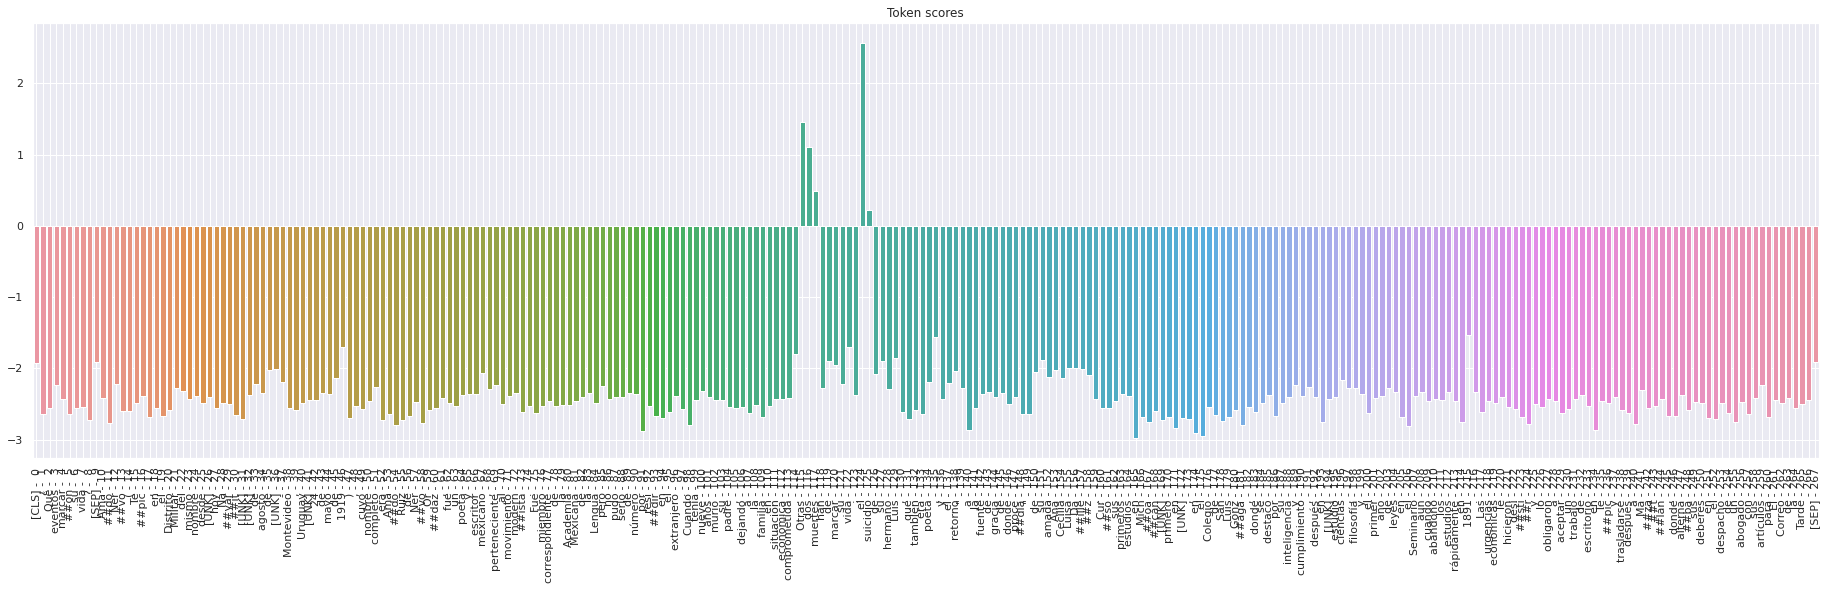

End scores


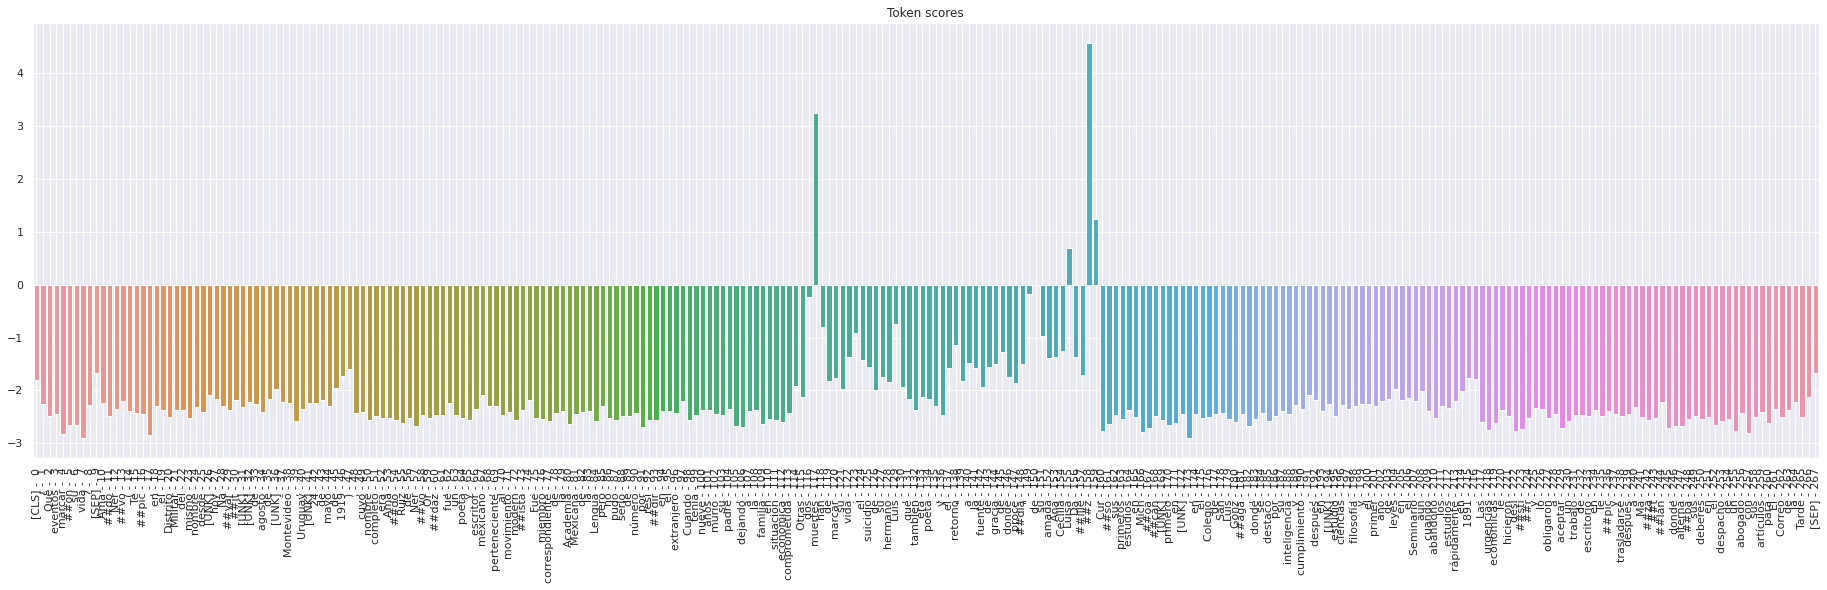

In [ ]:
# La pregunta ¿Qué eventos marcaron su vida? deberia responder "Cuando tenía nueve años murió su padre, dejando a la familia en situación económica comprometida. Otras dos muertes han de marcar su vida: el suicidio de su hermano Luis, que también era poeta, y el retorno "a la fuente de gracia de donde procedía" de su amada Ana Cecilia Luisa Daillez."

tokens, tokens_tensor, token_type_ids = get_tokens_tensors(questions[1], text)
predictions = model(tokens_tensor, token_type_ids=token_type_ids)
start_scores = predictions.start_logits
end_scores = predictions.end_logits

print("Start scores")
display_scores(tokens, start_scores.detach().numpy())
print("End scores")
display_scores(tokens, end_scores.detach().numpy())

Start scores


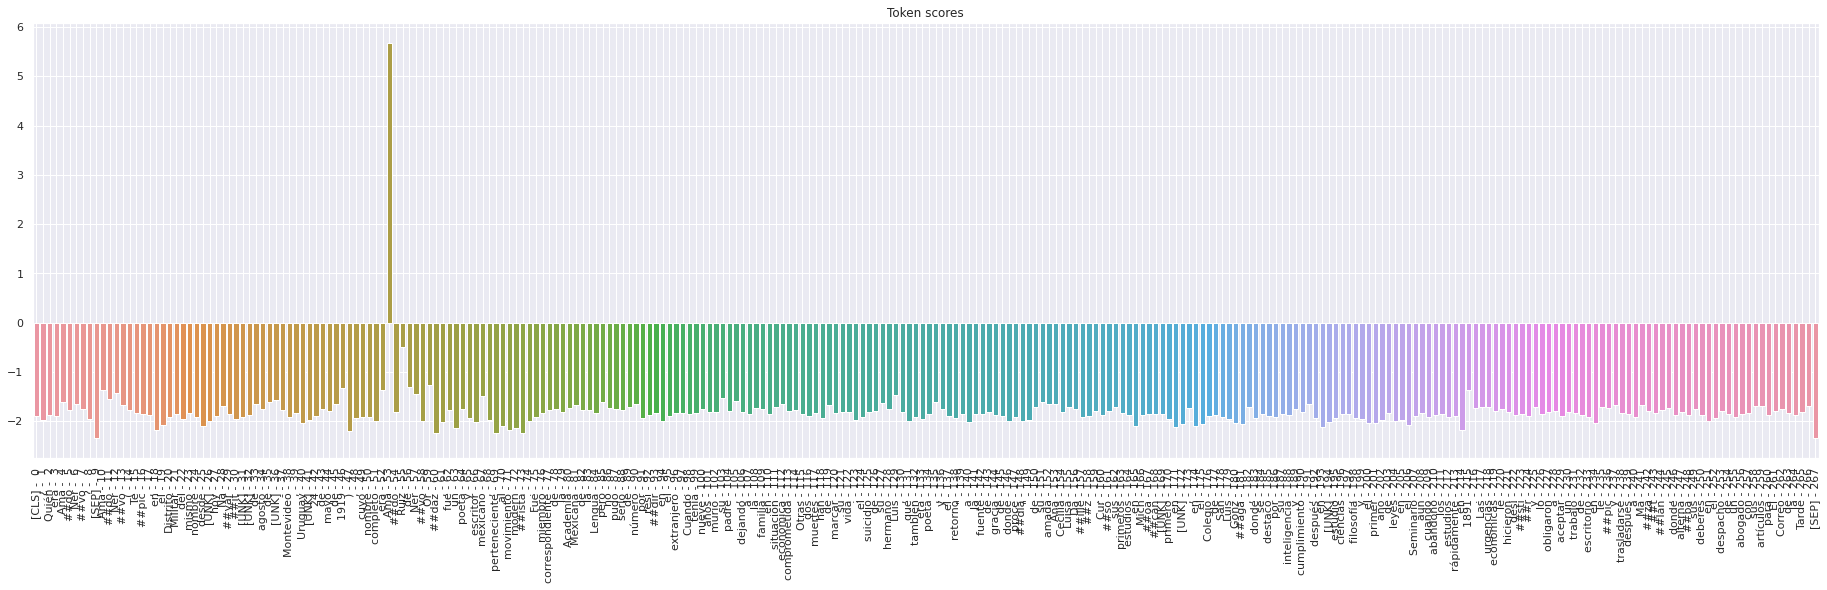

End scores


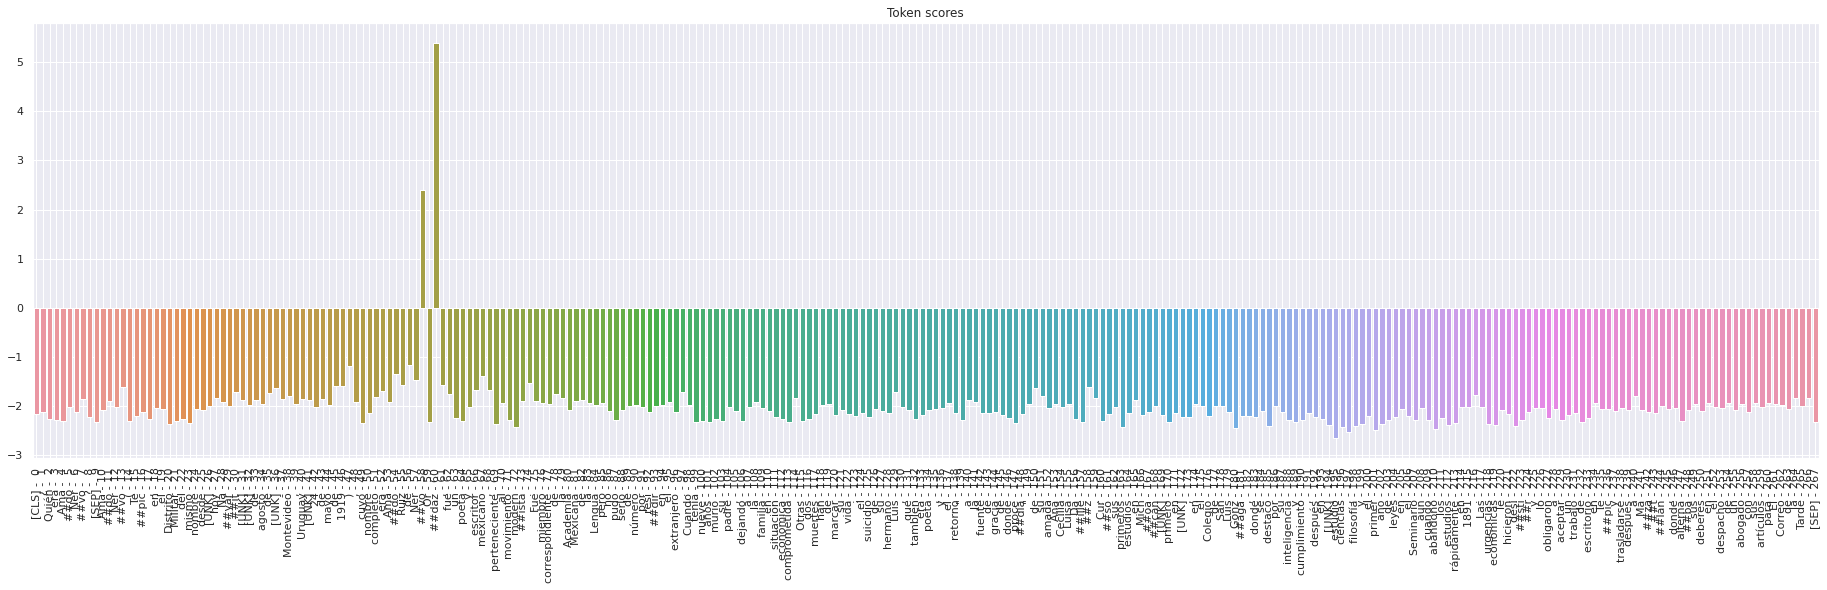

In [ ]:
# La pregunta ¿Quién era Amado Nervo? deberia responder "un poeta y escritor mexicano, perteneciente al movimiento modernista. Fue miembro correspondiente de la Academia Mexicana de la Lengua"

tokens, tokens_tensor, token_type_ids = get_tokens_tensors(questions[7], text)
predictions = model(tokens_tensor, token_type_ids=token_type_ids)
start_scores = predictions.start_logits
end_scores = predictions.end_logits

print("Start scores")
display_scores(tokens, start_scores.detach().numpy())
print("End scores")
display_scores(tokens, end_scores.detach().numpy())

Start scores


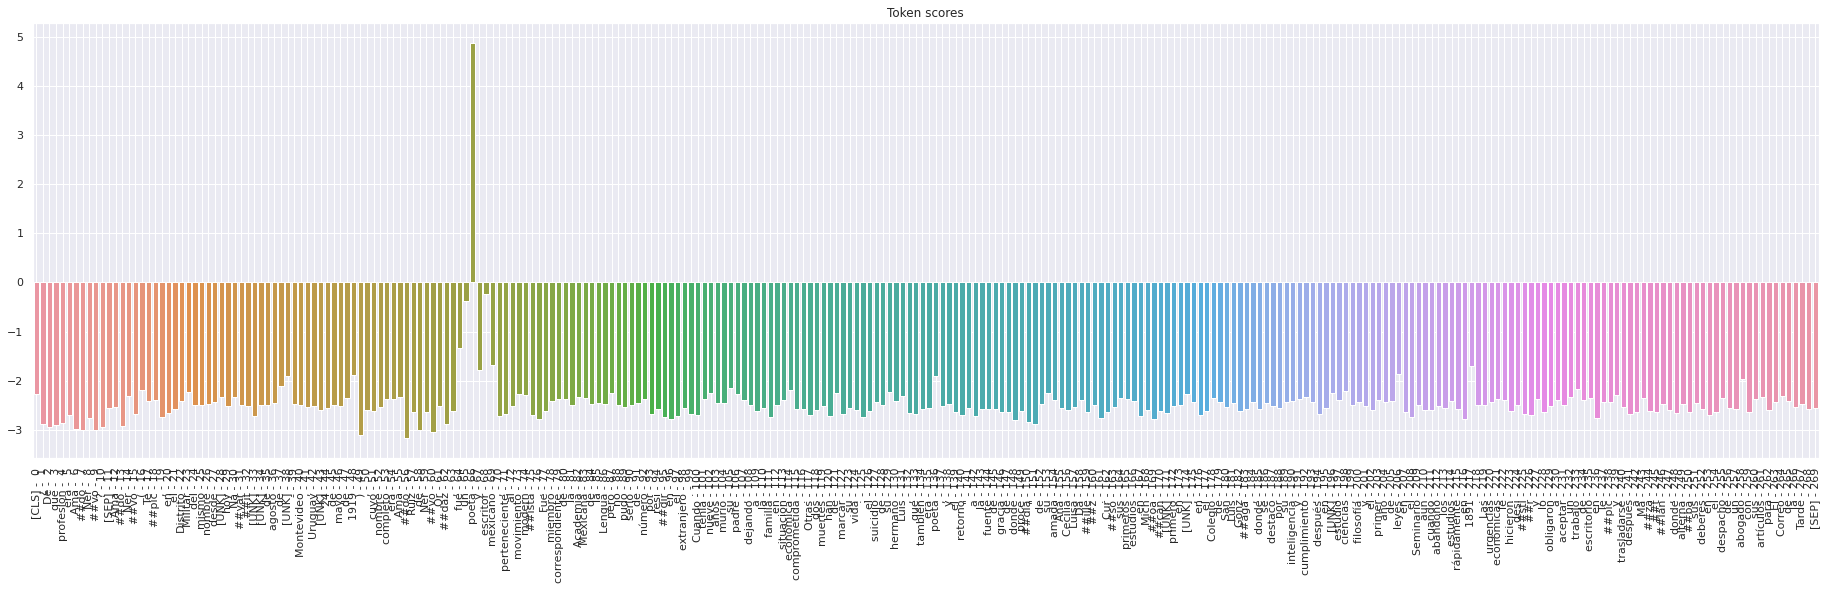

End scores


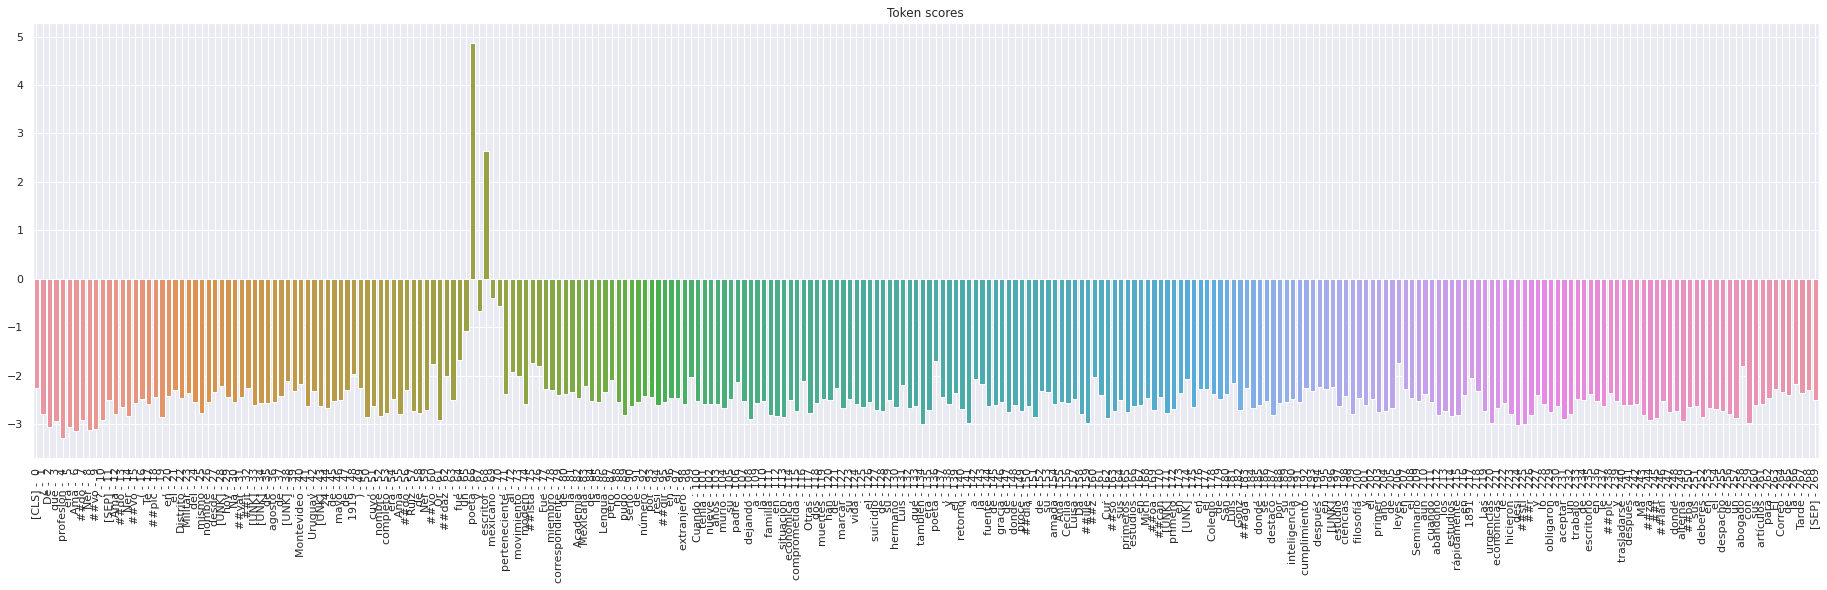

In [ ]:
# La pregunta ¿De qué profesión era Amado Nervo? deberia responder "poeta y escritor"

tokens, tokens_tensor, token_type_ids = get_tokens_tensors(questions[8], text)
predictions = model(tokens_tensor, token_type_ids=token_type_ids)
start_scores = predictions.start_logits
end_scores = predictions.end_logits

print("Start scores")
display_scores(tokens, start_scores.detach().numpy())
print("End scores")
display_scores(tokens, end_scores.detach().numpy())

## Clasificacacion de Texto

En los siguientes dos ejercicios se usará el mismo conjunto de datos del archivo amazon_baby.csv que usaste en la Tarea 2. Igualmente puedes apoyarte en los resultados obtenidos en dicha Tarea en relación a la limpieza de los datos.

In [ ]:
data = pd.read_csv("amazon_baby.csv")
print(data.shape)

(183531, 3)


In [ ]:
data.head()

,name,review,rating
0,Planetwise Flannel Wipes,"These flannel wipes are OK, but in my opinion ...",3
1,Planetwise Wipe Pouch,it came early and was not disappointed. i love...,5
2,Annas Dream Full Quilt with 2 Shams,Very soft and comfortable and warmer than it l...,5
3,Stop Pacifier Sucking without tears with Thumb...,This is a product well worth the purchase. I ...,5
4,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5


In [ ]:
data = data.drop(columns=["name"])
data.isnull().sum()

review    829
rating      0
dtype: int64

In [ ]:
# Debido a que hay 829 valores nulos, se van a eliminar
data = data.dropna()

In [ ]:
data.isnull().sum()

review    0
rating    0
dtype: int64

In [ ]:
data.shape

(182702, 2)

In [ ]:
x = data['review']
y = data['rating']

In [ ]:
unique, counts = np.unique(y,return_counts=True)
print(unique)
print(counts)

[1 2 3 4 5]
[ 15116  11277  16727  33099 106483]


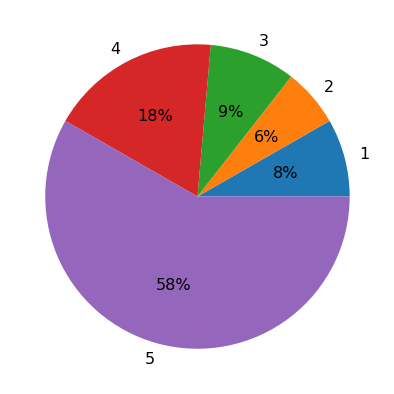

In [ ]:
plt.figure(figsize=(7,7))
plt.pie(counts,labels=["1","2","3","4","5"],autopct='%1.0f%%',textprops={'fontsize': 16})

plt.show()

In [ ]:
x_train_raw, x_val_test, y_train_raw, y_val_test = train_test_split(x, y, test_size=0.2, random_state=42)
x_val_raw, x_test_raw, y_val_raw, y_test_raw = train_test_split(x_val_test, y_val_test, test_size=0.5, random_state=42)

In [ ]:
def cleaning_reviews(sentence):
  words = sentence.split()
  return [w.lower() if w.isalnum() else re.sub("[^A-Za-z']+",' ',w.lower()) for w in words ]

In [ ]:
x_train = [cleaning_reviews(s) for s in x_train_raw]
x_val = [cleaning_reviews(s) for s in x_val_raw]
x_test = [cleaning_reviews(s) for s in x_test_raw]

In [ ]:
list(x_train_raw)[0]

"I used this on my little one starting at about two weeks and seven pounds. The fit wasn't great at that age, but better when he weighed about eight and a half pounds. The double gusset on the legs really does keep the poop contained.  After three months the elastic and Velcro are still holding strong. I took off a star because sometimes the top of the waist band folds in, and the Velcro rubs on his tummy and leaves a red mark. Would buy again."

In [ ]:
" ".join(x_train[0])

"i used this on my little one starting at about two weeks and seven pounds  the fit wasn't great at that age  but better when he weighed about eight and a half pounds  the double gusset on the legs really does keep the poop contained  after three months the elastic and velcro are still holding strong  i took off a star because sometimes the top of the waist band folds in  and the velcro rubs on his tummy and leaves a red mark  would buy again "

In [ ]:
y.unique()

array([3, 5, 4, 2, 1])

In [ ]:
enc = OneHotEncoder()
y_train = enc.fit_transform(y_train_raw.values.reshape(-1,1)).toarray()
y_val = enc.fit_transform(y_val_raw.values.reshape(-1,1)).toarray()
y_test = enc.fit_transform(y_test_raw.values.reshape(-1,1)).toarray()

In [ ]:
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(146161, 5)
(18270, 5)
(18271, 5)


In [ ]:
print(len(x_train))
print(len(y_train))
print(len(x_val))
print(len(y_val))
print(len(x_test))
print(len(y_test))

146161
146161
18270
18270
18271
18271


### GloVe embedding en RNN

2. Utiliza el método de GloVe embedding para obtener la representación embebida de cada palabra
de los comentarios del archivo amazon_baby. De preferenica utilizar la librería SpaCy
(https://spacy.io/), ( https://spacy.io/models/en ) con los vectores embedidos de dimensión 300
como lo vimos en el ejercicio en clase. NOTA: si tienes problemas de recursos de memoria, puedes
usar los vectores de dimensión 50 que encuentras en la página de GloVe
(https://nlp.stanford.edu/projects/glove/ ).

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2021-06-06 15:20:00--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-06-06 15:20:00--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-06-06 15:20:00--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [ ]:
!unzip -q glove.6B.zip

In [ ]:
os.listdir()

['glove.6B.100d.txt',
 'glove.6B.200d.txt',
 'glove.6B.50d.txt',
 'glove.6B.300d.txt',
 'glove.6B.zip',
 'pytorch_model.bin',
 'amazon_baby.csv',
 'vocab.txt',
 'config.json',
 'pytorch_model.bin.1',
 'vocab.txt.1',
 'config.json.1']

In [ ]:
embeddings_dict = dict()
embeddings_300_file = open('glove.6B.300d.txt')
for line in embeddings_300_file:
  values = line.split()
  word = values[0]
  coefs = np.array(values[1:],dtype='float32')
  embeddings_dict[word] = coefs

embeddings_300_file.close()
print('Loaded %s word vectors.' % len(embeddings_dict))

Loaded 400000 word vectors.


In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train)
vocab_size = len(tokenizer.word_index) + 1

In [ ]:
encoded_docs_train = tokenizer.texts_to_sequences(x_train)
encoded_docs_val = tokenizer.texts_to_sequences(x_val)
encoded_docs_test = tokenizer.texts_to_sequences(x_test)

In [ ]:
count_sent_size = 0
for line in encoded_docs_train:
  count_sent_size += len(line)
avg_sent_size = count_sent_size / len(encoded_docs_train)
print(avg_sent_size)
sent_length = math.floor(avg_sent_size)

81.77916817755762


In [ ]:
# padding sentences with the average size of the sentences
padded_docs_train = pad_sequences(encoded_docs_train,maxlen=sent_length,padding='post')
padded_docs_val = pad_sequences(encoded_docs_val,maxlen=sent_length,padding='post')
padded_docs_test = pad_sequences(encoded_docs_test,maxlen=sent_length,padding='post')

print(type(padded_docs_train))
print(padded_docs_train.shape)
print(padded_docs_val.shape)
print(padded_docs_test.shape)


<class 'numpy.ndarray'>
(146161, 81)
(18270, 81)
(18271, 81)


#### Comparacion de modelos RNN, GRU y LSTM

3. Utiliza la representación embebida de dichos datos como entrada a un modelo basado en redes recurentes (RNN, GRU, LSTM) para la clasificación de los comentarios a los productos en Amazon_Baby. NOTA: La partición de los datos en conjunto de entrenamiento, validación y prueba, así como la arquitectura del modelo, es abierta.

In [ ]:
def conf_mat(model, x_val_pad, y_val, binary=False):
  y_pred = model.predict(x_val_pad)
  if binary:
    y_pred = tf.greater(y_pred,0.5)
    labels = ["Negative", "Positive"]
  else:
    y_pred = y_pred.argmax(axis=1)+1 # the one was added here since the lables are from 1 to 5
    y_val = y_val.argmax(axis=1) + 1
    labels = ["1", "2","3","4","5"]
  cm = confusion_matrix(y_val, y_pred,normalize='true')
  
  pd_cm = pd.DataFrame(cm, index = labels, columns=labels)
  plt.figure(figsize=(10,5))
  g = sn.heatmap(pd_cm, annot=True, cmap="Blues", fmt="f", annot_kws={"fontsize":15})
  g.set_xticklabels(g.get_xmajorticklabels(), fontsize = 13)
  g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 13)
  plt.yticks(rotation=0)
  plt.xlabel('Predicted labels')
  plt.ylabel('True labels')
  plt.show()

  print(classification_report(y_val, y_pred))

In [ ]:
def plot_results(H, n_epochs):
  plt.style.use("ggplot")
  plt.figure()
  plt.plot(np.arange(0,n_epochs),H.history["accuracy"],label="train_acc")
  plt.plot(np.arange(0,n_epochs),H.history["val_accuracy"],label="val_acc")
  plt.title("Training and Validation Accuracy")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy")
  plt.legend()

  plt.figure()
  plt.plot(np.arange(0,n_epochs),H.history["loss"],label="train_loss") 
  plt.plot(np.arange(0,n_epochs),H.history["val_loss"],label="val_loss")
  plt.title("Training and Validation Loss")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend()

  plt.show()

In [ ]:
# creating an embedded matrix for words in training docs
sz_vec = 300 # this size corresponds to the size of the embedding vectors we chose from the GloVe library 

embedding_matrix = np.zeros((vocab_size,sz_vec))
print(embedding_matrix.shape)

for word, i in tokenizer.word_index.items():
  embedding_vector = embeddings_dict.get(word)

  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector


(157234, 300)


In [ ]:
def model_train(x_train, y_train, x_val, y_val, vocab_size, sentence_len, embedding_size=128, embedding_matrix=embedding_matrix, verbose=True, n_epochs=10, n_batch=128, layers=1, bidirectional=True, units=128, normalization=False, layer_type="RNN", binary=False, learning_rate=0.01,**layer_params):
  Layer = SimpleRNN
  if layer_type == "GRU":
    Layer = GRU
  elif layer_type == "LSTM":
    Layer = LSTM

  model = Sequential()
  model.add(Embedding(input_dim=vocab_size, 
                       output_dim=embedding_size,
                     weights=[embedding_matrix], 
                     input_length=sentence_len, 
                     trainable=False))
  
  for i in range(layers):
    if bidirectional:
      model.add(Bidirectional(Layer(units=units, return_sequences=True,**layer_params)))
    else:
      model.add(Layer(units=units, return_sequences=True,**layer_params))
    if normalization:
      model.add(BatchNormalization())
  if binary:
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
  else:
    model.add(Flatten())
    model.add(Dense(5, activation='softmax'))
    # Compile model
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
  print(model.summary())

  start = time.time()
  H = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=n_epochs, verbose=verbose, batch_size=n_batch)
  end = time.time()
  print("Elapsed training time: ", end - start)

  plot_results(H, n_epochs)

  # Evaluate the model
  print("MODEL EVALUATION")
  preds = model.evaluate(x = x_val, y = y_val)

  print()
  print ("Loss = " + str(preds[0]))
  print ("Test Accuracy = " + str(preds[1]))
  accuracy = preds[1]

  print("CONFUSION MATRIX")
  if binary:
    conf_mat(model, x_val, y_val,binary=True)
  else:
    conf_mat(model, x_val, y_val)
  

  return model, accuracy

Simple RNN

In [ ]:
model_1 = Sequential()
model_1.add(Embedding(input_dim=vocab_size, output_dim=sz_vec,
                     weights=[embedding_matrix], 
                     input_length=sent_length, 
                     trainable=False))
model_1.add(Bidirectional(SimpleRNN(units=128,return_sequences=True)))
model_1.add(Flatten())
model_1.add(Dense(5, activation='softmax'))

model_1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 81, 300)           47170200  
_________________________________________________________________
bidirectional (Bidirectional (None, 81, 256)           109824    
_________________________________________________________________
flatten (Flatten)            (None, 20736)             0         
_________________________________________________________________
dense (Dense)                (None, 5)                 103685    
Total params: 47,383,709
Trainable params: 213,509
Non-trainable params: 47,170,200
_________________________________________________________________


In [ ]:
print(type(padded_docs_train))
print(type(y_train))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [ ]:
n_epochs=8
n_batch=128

In [ ]:
H = model_1.fit(padded_docs_train, y_train, validation_data=(padded_docs_val, y_val), epochs=n_epochs, batch_size=n_batch)

Epoch 1/8
1142/1142 [==============================] - 197s 150ms/step - loss: 1.2552 - accuracy: 0.5578 - val_loss: 1.1442 - val_accuracy: 0.5787
Epoch 2/8
1142/1142 [==============================] - 167s 146ms/step - loss: 1.0392 - accuracy: 0.6138 - val_loss: 1.1110 - val_accuracy: 0.5845
Epoch 3/8
1142/1142 [==============================] - 167s 146ms/step - loss: 0.9896 - accuracy: 0.6293 - val_loss: 1.0902 - val_accuracy: 0.5927
Epoch 4/8
1142/1142 [==============================] - 168s 147ms/step - loss: 0.9449 - accuracy: 0.6430 - val_loss: 1.1487 - val_accuracy: 0.5758
Epoch 5/8
1142/1142 [==============================] - 168s 147ms/step - loss: 0.9226 - accuracy: 0.6510 - val_loss: 1.1346 - val_accuracy: 0.5812
Epoch 6/8
1142/1142 [==============================] - 163s 143ms/step - loss: 0.9062 - accuracy: 0.6590 - val_loss: 1.1259 - val_accuracy: 0.5964
Epoch 7/8
1142/1142 [==============================] - 165s 145ms/step - loss: 0.8995 - accuracy: 0.6619 - val_loss: 1

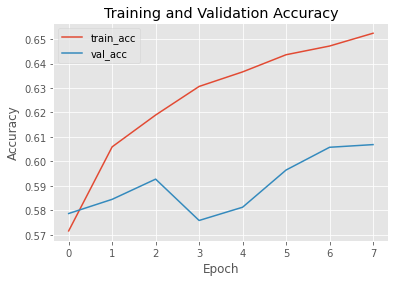

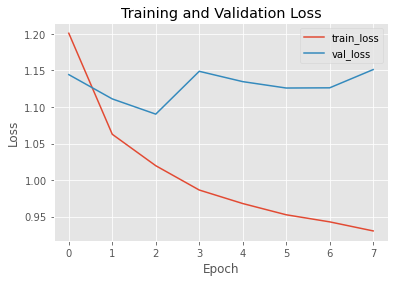

In [ ]:
plot_results(H, n_epochs)

In [ ]:
model_1.evaluate(x = padded_docs_test, y = y_test)

571/571 [==============================] - 8s 14ms/step - loss: 1.1567 - accuracy: 0.6105


[1.15666663646698, 0.6105303764343262]

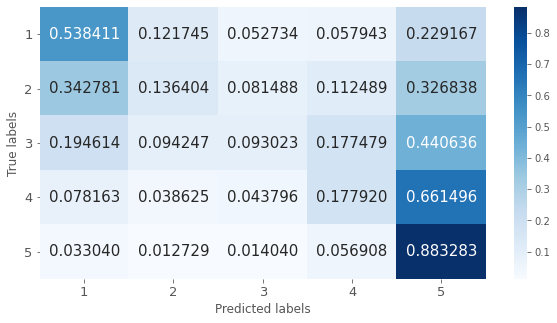

In [ ]:
conf_mat(model_1, padded_docs_test, y_test_raw)

In [ ]:
confusion_matrix()

GRU una capa

In [ ]:
model_2 = Sequential()
model_2.add(Embedding(input_dim=vocab_size, output_dim=sz_vec,
                     weights=[embedding_matrix], 
                     input_length=sent_length, 
                     trainable=False))
model_2.add(Bidirectional(GRU(units=128,return_sequences=True)))
model_2.add(Flatten())
model_2.add(Dense(5, activation='softmax'))

model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 81, 300)           47170200  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 81, 256)           330240    
_________________________________________________________________
flatten_1 (Flatten)          (None, 20736)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 103685    
Total params: 47,604,125
Trainable params: 433,925
Non-trainable params: 47,170,200
_________________________________________________________________


In [ ]:
H = model_2.fit(padded_docs_train, y_train, validation_data=(padded_docs_val, y_val), epochs=n_epochs, batch_size=n_batch)

Epoch 1/8
1142/1142 [==============================] - 32s 21ms/step - loss: 1.0527 - accuracy: 0.6029 - val_loss: 0.8997 - val_accuracy: 0.6514
Epoch 2/8
1142/1142 [==============================] - 23s 20ms/step - loss: 0.8331 - accuracy: 0.6757 - val_loss: 0.8809 - val_accuracy: 0.6569
Epoch 3/8
1142/1142 [==============================] - 23s 20ms/step - loss: 0.7502 - accuracy: 0.7104 - val_loss: 0.9129 - val_accuracy: 0.6473
Epoch 4/8
1142/1142 [==============================] - 22s 20ms/step - loss: 0.6704 - accuracy: 0.7409 - val_loss: 0.9841 - val_accuracy: 0.6621
Epoch 5/8
1142/1142 [==============================] - 23s 20ms/step - loss: 0.5804 - accuracy: 0.7761 - val_loss: 1.0409 - val_accuracy: 0.6436
Epoch 6/8
1142/1142 [==============================] - 23s 20ms/step - loss: 0.4938 - accuracy: 0.8127 - val_loss: 1.1492 - val_accuracy: 0.6316
Epoch 7/8
1142/1142 [==============================] - 23s 20ms/step - loss: 0.4046 - accuracy: 0.8484 - val_loss: 1.2964 - val_ac

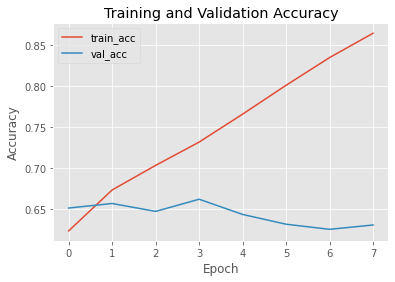

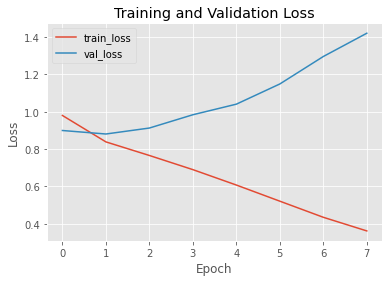

In [ ]:
plot_results(H, n_epochs)

In [ ]:
model_2.evaluate(x = padded_docs_test, y = y_test)

571/571 [==============================] - 4s 6ms/step - loss: 1.4246 - accuracy: 0.6348


[1.4245750904083252, 0.6347764134407043]

GRU dos capas

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 81, 300)           47170200  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 81, 256)           330240    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 81, 256)           296448    
_________________________________________________________________
flatten_1 (Flatten)          (None, 20736)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 103685    
Total params: 47,900,573
Trainable params: 730,373
Non-trainable params: 47,170,200
_________________________________________________________________
None
Epoch 1/10
1142/1142 [==============================] - 68s 35ms/step - loss: 3.6988 - accuracy: 

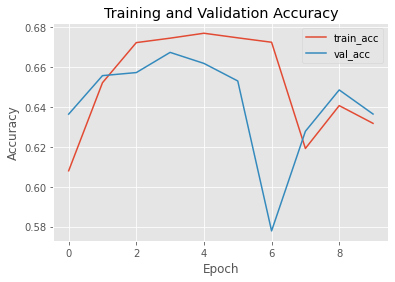

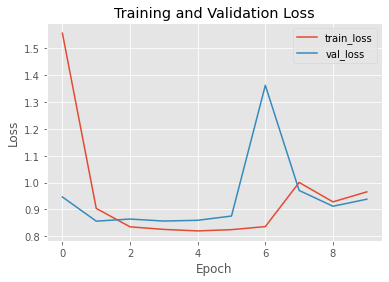

MODEL EVALUATION
571/571 [==============================] - 5s 9ms/step - loss: 0.9378 - accuracy: 0.6365

Loss = 0.937816858291626
Test Accuracy = 0.6364532113075256
CONFUSION MATRIX


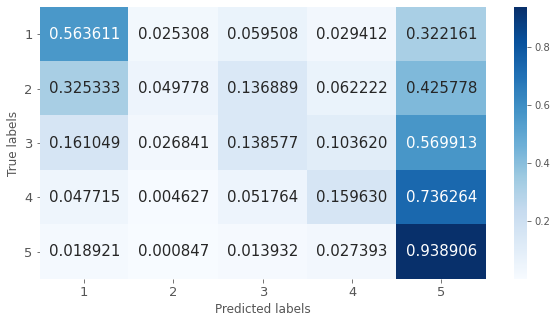

              precision    recall  f1-score   support

           1       0.45      0.56      0.50      1462
           2       0.35      0.05      0.09      1125
           3       0.28      0.14      0.19      1602
           4       0.49      0.16      0.24      3458
           5       0.69      0.94      0.80     10623

    accuracy                           0.64     18270
   macro avg       0.45      0.37      0.36     18270
weighted avg       0.58      0.64      0.57     18270



(<keras.engine.sequential.Sequential at 0x7f9e6013ff50>, 0.6364532113075256)

In [ ]:
model_train(padded_docs_train, y_train, padded_docs_val, y_val, vocab_size, sent_length, embedding_size=sz_vec, embedding_matrix=embedding_matrix, verbose=True, n_epochs=10, n_batch=128, layers=2, bidirectional=True, units=128, normalization=False, layer_type="GRU")

LSTM una capa

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 81, 300)           47170200  
_________________________________________________________________
bidirectional_3 (Bidirection (None, 81, 256)           439296    
_________________________________________________________________
flatten_2 (Flatten)          (None, 20736)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 103685    
Total params: 47,713,181
Trainable params: 542,981
Non-trainable params: 47,170,200
_________________________________________________________________
None
Epoch 1/10
1142/1142 [==============================] - 30s 23ms/step - loss: 1.7195 - accuracy: 0.5917 - val_loss: 0.9141 - val_accuracy: 0.6473
Epoch 2/10
1142/1142 [==============================] - 25s 22ms/step - loss: 0.845

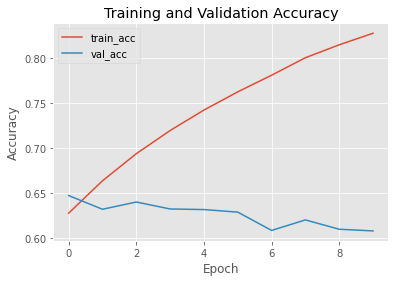

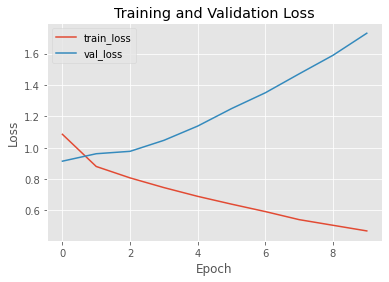

MODEL EVALUATION
571/571 [==============================] - 4s 7ms/step - loss: 1.7291 - accuracy: 0.6081

Loss = 1.7291381359100342
Test Accuracy = 0.6081007122993469
CONFUSION MATRIX


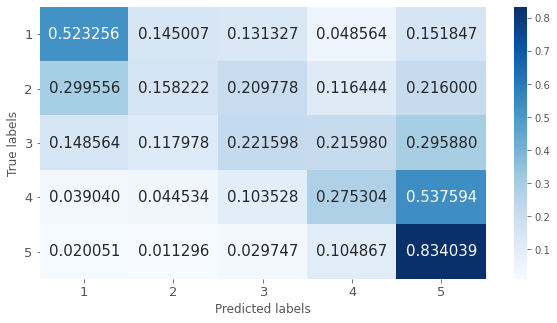

              precision    recall  f1-score   support

           1       0.45      0.52      0.49      1462
           2       0.21      0.16      0.18      1125
           3       0.24      0.22      0.23      1602
           4       0.36      0.28      0.31      3458
           5       0.76      0.83      0.80     10623

    accuracy                           0.61     18270
   macro avg       0.41      0.40      0.40     18270
weighted avg       0.58      0.61      0.59     18270



(<keras.engine.sequential.Sequential at 0x7f9e23f52b10>, 0.6081007122993469)

In [ ]:
model_train(padded_docs_train, y_train, padded_docs_val, y_val, vocab_size, sent_length, embedding_size=sz_vec, embedding_matrix=embedding_matrix, verbose=True, n_epochs=10, n_batch=128, layers=1, bidirectional=True, units=128, normalization=False, layer_type="LSTM")

LSTM dos capas

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 81, 300)           47170200  
_________________________________________________________________
bidirectional_4 (Bidirection (None, 81, 256)           439296    
_________________________________________________________________
bidirectional_5 (Bidirection (None, 81, 256)           394240    
_________________________________________________________________
flatten_3 (Flatten)          (None, 20736)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 103685    
Total params: 48,107,421
Trainable params: 937,221
Non-trainable params: 47,170,200
_________________________________________________________________
None
Epoch 1/10
1142/1142 [==============================] - 52s 41ms/step - loss: 2.3551 - accuracy: 

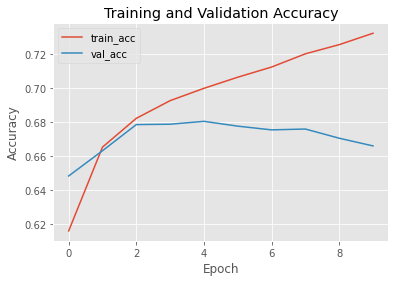

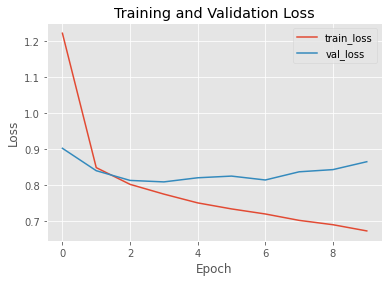

MODEL EVALUATION
571/571 [==============================] - 6s 10ms/step - loss: 0.8649 - accuracy: 0.6659

Loss = 0.8648769855499268
Test Accuracy = 0.6659004092216492
CONFUSION MATRIX


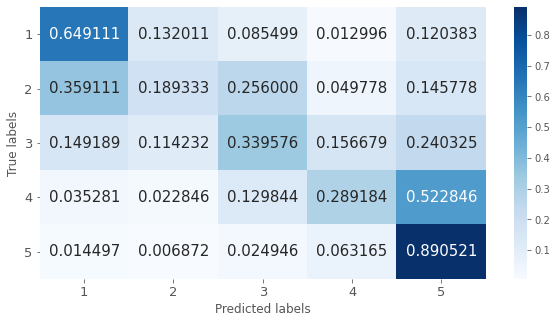

              precision    recall  f1-score   support

           1       0.51      0.65      0.57      1462
           2       0.29      0.19      0.23      1125
           3       0.33      0.34      0.33      1602
           4       0.50      0.29      0.37      3458
           5       0.79      0.89      0.84     10623

    accuracy                           0.67     18270
   macro avg       0.48      0.47      0.47     18270
weighted avg       0.64      0.67      0.64     18270



(<keras.engine.sequential.Sequential at 0x7f9e202c8810>, 0.6659004092216492)

In [ ]:
model_train(padded_docs_train, y_train, padded_docs_val, y_val, vocab_size, sent_length, embedding_size=sz_vec, embedding_matrix=embedding_matrix, verbose=True, n_epochs=10, n_batch=128, layers=2, bidirectional=True, units=128, normalization=False, layer_type="LSTM")

In [ ]:
params = {'dropout':0.25}

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 81, 300)           47170200  
_________________________________________________________________
bidirectional (Bidirectional (None, 81, 256)           439296    
_________________________________________________________________
batch_normalization (BatchNo (None, 81, 256)           1024      
_________________________________________________________________
bidirectional_1 (Bidirection (None, 81, 256)           394240    
_________________________________________________________________
batch_normalization_1 (Batch (None, 81, 256)           1024      
_________________________________________________________________
flatten (Flatten)            (None, 20736)             0         
_________________________________________________________________
dense (Dense)                (None, 5)                 1

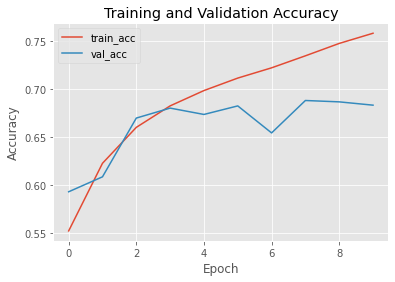

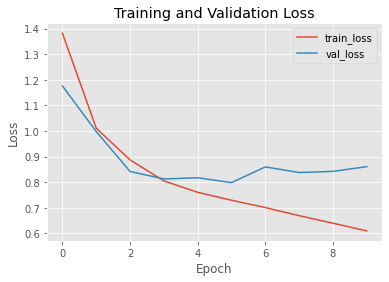

MODEL EVALUATION
571/571 [==============================] - 8s 14ms/step - loss: 0.8609 - accuracy: 0.6833

Loss = 0.8609181046485901
Test Accuracy = 0.6833059787750244
CONFUSION MATRIX


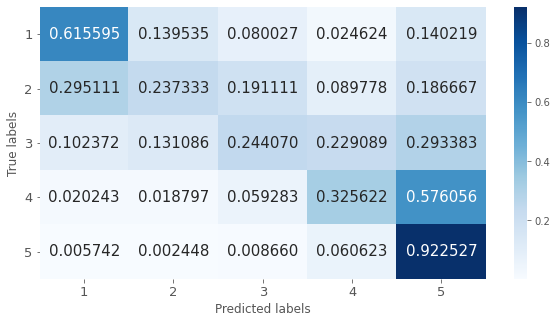

              precision    recall  f1-score   support

           1       0.59      0.62      0.60      1462
           2       0.35      0.24      0.28      1125
           3       0.38      0.24      0.30      1602
           4       0.50      0.33      0.39      3458
           5       0.77      0.92      0.84     10623

    accuracy                           0.68     18270
   macro avg       0.52      0.47      0.48     18270
weighted avg       0.65      0.68      0.66     18270



(<keras.engine.sequential.Sequential at 0x7f9eb0874a50>, 0.6833059787750244)

In [ ]:
model_train(padded_docs_train, y_train, padded_docs_val, y_val, vocab_size, sent_length, embedding_size=sz_vec, embedding_matrix=embedding_matrix, verbose=True, n_epochs=10, n_batch=128, layers=2, bidirectional=True, units=128, normalization=True, layer_type="LSTM",binary=False,learning_rate=0.001,**params)

LSTM tres capas

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 81, 300)           47170200  
_________________________________________________________________
bidirectional_2 (Bidirection (None, 81, 256)           439296    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 81, 256)           394240    
_________________________________________________________________
bidirectional_4 (Bidirection (None, 81, 256)           394240    
_________________________________________________________________
flatten_1 (Flatten)          (None, 20736)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 103685    
Total params: 48,501,661
Trainable params: 1,331,461
Non-trainable params: 47,170,200
__________________________________

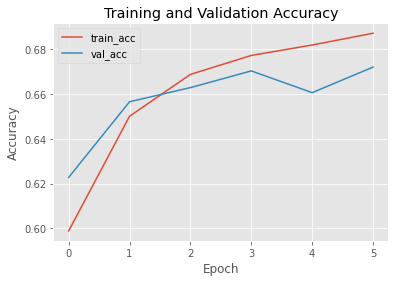

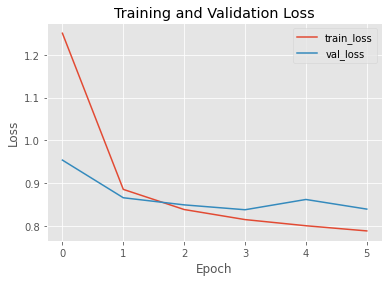

MODEL EVALUATION
571/571 [==============================] - 11s 20ms/step - loss: 0.8392 - accuracy: 0.6719

Loss = 0.8392127156257629
Test Accuracy = 0.6719211935997009
CONFUSION MATRIX


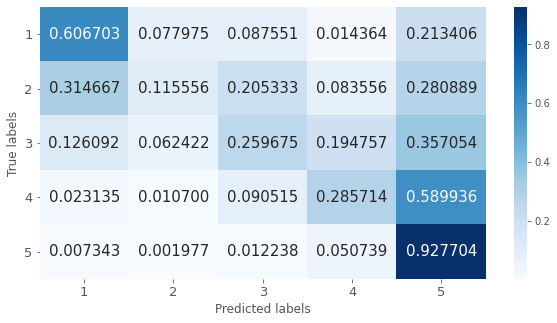

              precision    recall  f1-score   support

           1       0.55      0.61      0.58      1462
           2       0.32      0.12      0.17      1125
           3       0.34      0.26      0.30      1602
           4       0.51      0.29      0.37      3458
           5       0.75      0.93      0.83     10623

    accuracy                           0.67     18270
   macro avg       0.50      0.44      0.45     18270
weighted avg       0.63      0.67      0.63     18270



(<keras.engine.sequential.Sequential at 0x7f9e0a128050>, 0.6719211935997009)

In [ ]:
model_train(padded_docs_train, y_train, padded_docs_val, y_val, vocab_size, sent_length, embedding_size=sz_vec, embedding_matrix=embedding_matrix, verbose=True, n_epochs=6, n_batch=128, layers=3, bidirectional=True, units=128, normalization=False, layer_type="LSTM")

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 81, 300)           47170200  
_________________________________________________________________
bidirectional_9 (Bidirection (None, 81, 256)           439296    
_________________________________________________________________
bidirectional_10 (Bidirectio (None, 81, 256)           394240    
_________________________________________________________________
bidirectional_11 (Bidirectio (None, 81, 256)           394240    
_________________________________________________________________
flatten_5 (Flatten)          (None, 20736)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 103685    
Total params: 48,501,661
Trainable params: 1,331,461
Non-trainable params: 47,170,200
__________________________________

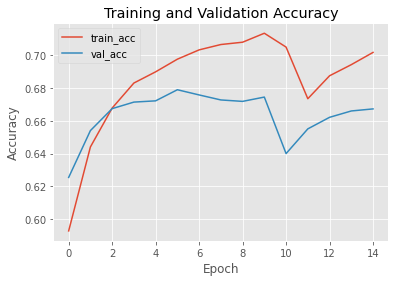

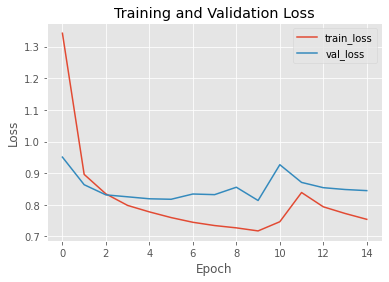

MODEL EVALUATION
571/571 [==============================] - 8s 14ms/step - loss: 0.8448 - accuracy: 0.6673

Loss = 0.8447979092597961
Test Accuracy = 0.6672687530517578
CONFUSION MATRIX


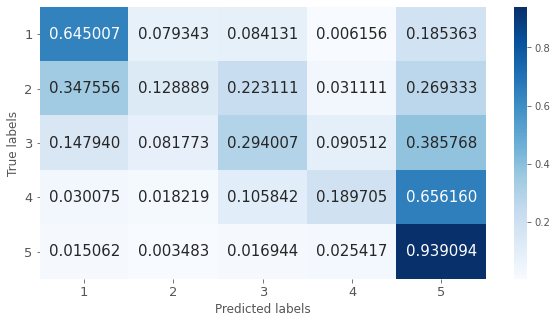

              precision    recall  f1-score   support

           1       0.51      0.65      0.57      1462
           2       0.29      0.13      0.18      1125
           3       0.34      0.29      0.31      1602
           4       0.59      0.19      0.29      3458
           5       0.74      0.94      0.83     10623

    accuracy                           0.67     18270
   macro avg       0.50      0.44      0.44     18270
weighted avg       0.63      0.67      0.62     18270



(<keras.engine.sequential.Sequential at 0x7f9d6a5aee10>, 0.6672687530517578)

In [ ]:
model_train(padded_docs_train, y_train, padded_docs_val, y_val, vocab_size, sent_length, embedding_size=sz_vec, embedding_matrix=embedding_matrix, verbose=True, n_epochs=15, n_batch=128, layers=3, bidirectional=True, units=128, normalization=False, layer_type="LSTM")

### Creación de dataset clasificación binaria
Debido a que se observó que es difícil conseguir un modelo preciso que pueda detectar específicamente el "rating" del 1 al 5, se decidió crear un dataset dividiendo los comentarios en positivos y negativos. Los comentarios con una puntuación de 1,2 y 3 forman la clase negativa, mientras que los de 4 y 5 estrellas forman la clase positiva. 

In [ ]:
x_train_raw[11253]

"This has been the best twenty bucks I have spent in recent memory. Lightweight, easy to clean and sturdy. Folds up perfectly. can't say enough good things about it!!! buy it"

In [ ]:
y_train_raw[11253]

5

In [ ]:
y_train[11253]

array([0., 0., 0., 0., 1.])

In [ ]:
y_train_binary = np.array([0 if rating == 1 or rating == 2 or rating == 3 else 1 for rating in y_train_raw])
y_val_binary = np.array([0 if rating == 1 or rating == 2 or rating == 3 else 1 for rating in y_val_raw])
y_test_binary = np.array([0 if rating == 1 or rating == 2 or rating == 3 else 1 for rating in y_test_raw])

In [ ]:
print(len(padded_docs_train))
print(len(y_train_binary))
print(len(padded_docs_val))
print(len(y_val_binary))
print(len(padded_docs_test))
print(len(y_test_binary))

In [ ]:
y_binary = [0 if rating <= 3 else 1 for rating in y]
unique_binary, unique_counts = np.unique(y_binary, return_counts=True)
print(unique_binary, unique_counts)

[0 1] [ 43120 139582]


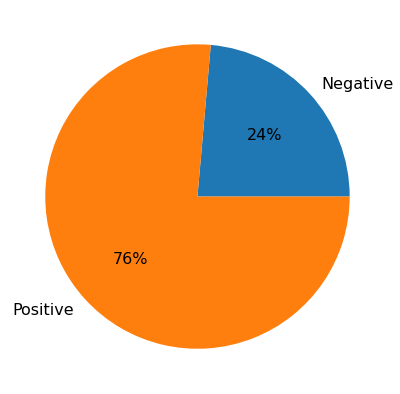

In [ ]:
plt.figure(figsize=(7,7))
plt.pie(unique_counts,labels=["Negative","Positive"],autopct='%1.0f%%',textprops={'fontsize': 16})

plt.show()

In [ ]:
print(type(y_val))
print(type(y_val_binary))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 81, 300)           47170200  
_________________________________________________________________
bidirectional_12 (Bidirectio (None, 81, 256)           330240    
_________________________________________________________________
flatten_6 (Flatten)          (None, 20736)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 20737     
Total params: 47,521,177
Trainable params: 350,977
Non-trainable params: 47,170,200
_________________________________________________________________
None
Epoch 1/10
1142/1142 [==============================] - 27s 21ms/step - loss: 0.6447 - accuracy: 0.7976 - val_loss: 0.4372 - val_accuracy: 0.8340
Epoch 2/10
1142/1142 [==============================] - 22s 20ms/step - loss: 0.421

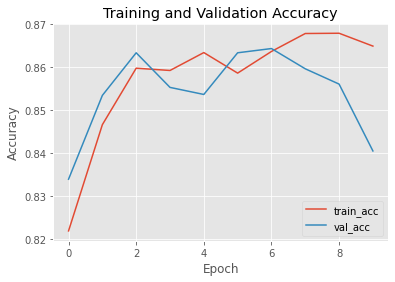

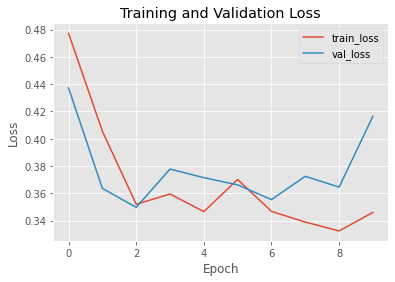

MODEL EVALUATION
571/571 [==============================] - 3s 6ms/step - loss: 0.4164 - accuracy: 0.8406

Loss = 0.41643476486206055
Test Accuracy = 0.8405582904815674
CONFUSION MATRIX


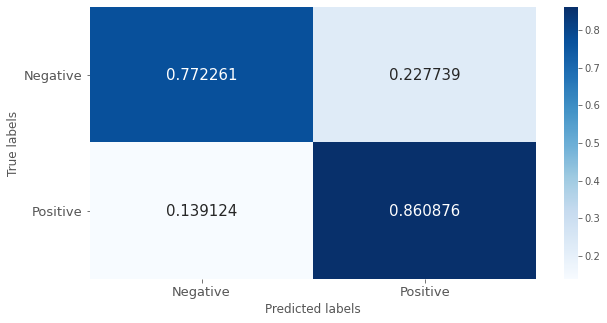

              precision    recall  f1-score   support

           0       0.62      0.77      0.69      4189
           1       0.93      0.86      0.89     14081

    accuracy                           0.84     18270
   macro avg       0.77      0.82      0.79     18270
weighted avg       0.86      0.84      0.85     18270



(<keras.engine.sequential.Sequential at 0x7f9d26dee3d0>, 0.8405582904815674)

In [ ]:
model_train(padded_docs_train, y_train_binary, padded_docs_val, y_val_binary, vocab_size, sent_length, embedding_size=sz_vec, embedding_matrix=embedding_matrix, verbose=True, n_epochs=10, n_batch=128, layers=1, bidirectional=True, units=128, normalization=False, layer_type="GRU",binary=True)

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_19 (Embedding)     (None, 81, 300)           47170200  
_________________________________________________________________
bidirectional_28 (Bidirectio (None, 81, 256)           330240    
_________________________________________________________________
batch_normalization (BatchNo (None, 81, 256)           1024      
_________________________________________________________________
bidirectional_29 (Bidirectio (None, 81, 256)           296448    
_________________________________________________________________
batch_normalization_1 (Batch (None, 81, 256)           1024      
_________________________________________________________________
flatten_15 (Flatten)         (None, 20736)             0         
_________________________________________________________________
dense_15 (Dense)             (None, 1)               

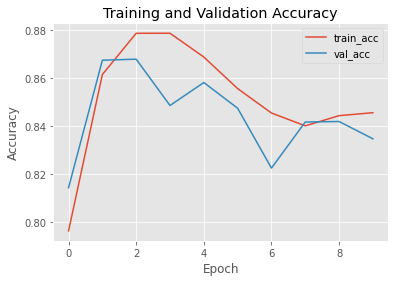

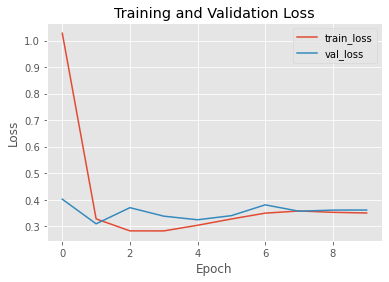

MODEL EVALUATION
571/571 [==============================] - 6s 10ms/step - loss: 0.3609 - accuracy: 0.8348

Loss = 0.36091676354408264
Test Accuracy = 0.8347564339637756
CONFUSION MATRIX


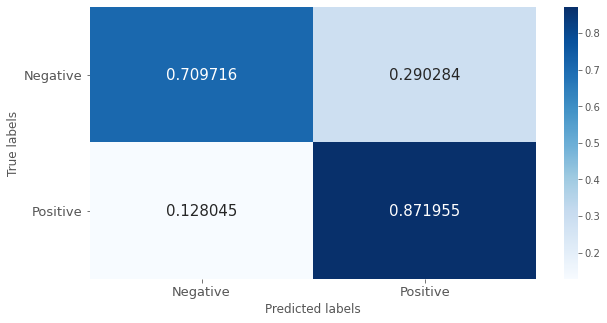

(<keras.engine.sequential.Sequential at 0x7f967891e090>, 0.8347564339637756)

In [ ]:
model_train(padded_docs_train, y_train_binary, padded_docs_val, y_val_binary, vocab_size, sent_length, embedding_size=sz_vec, embedding_matrix=embedding_matrix, verbose=True, n_epochs=10, n_batch=128, layers=2, bidirectional=True, units=128, normalization=True, layer_type="GRU",binary=True)

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_21 (Embedding)     (None, 81, 300)           47170200  
_________________________________________________________________
bidirectional_32 (Bidirectio (None, 81, 256)           439296    
_________________________________________________________________
flatten_17 (Flatten)         (None, 20736)             0         
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 20737     
Total params: 47,630,233
Trainable params: 460,033
Non-trainable params: 47,170,200
_________________________________________________________________
None
Epoch 1/10
1142/1142 [==============================] - 27s 21ms/step - loss: 0.6814 - accuracy: 0.8014 - val_loss: 0.3067 - val_accuracy: 0.8684
Epoch 2/10
1142/1142 [==============================] - 23s 21ms/step - loss: 0.28

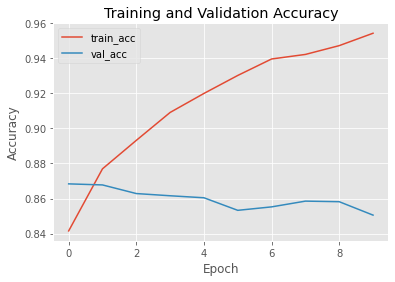

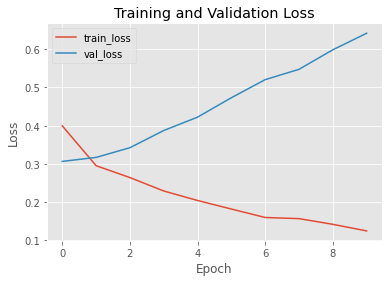

MODEL EVALUATION
571/571 [==============================] - 4s 7ms/step - loss: 0.6415 - accuracy: 0.8505

Loss = 0.6415326595306396
Test Accuracy = 0.8505199551582336
CONFUSION MATRIX


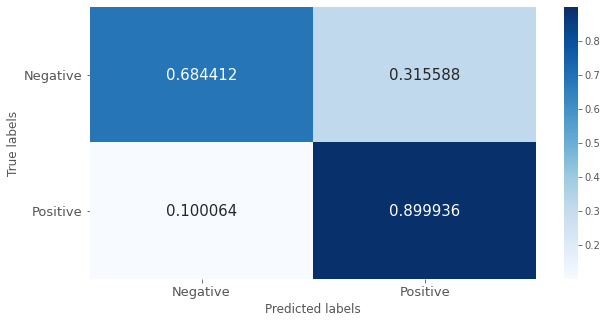

(<keras.engine.sequential.Sequential at 0x7f9672ebea10>, 0.8505199551582336)

In [ ]:
model_train(padded_docs_train, y_train_binary, padded_docs_val, y_val_binary, vocab_size, sent_length, embedding_size=sz_vec, embedding_matrix=embedding_matrix, verbose=True, n_epochs=10, n_batch=128, layers=1, bidirectional=True, units=128, normalization=False, layer_type="LSTM",binary=True)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 81, 300)           47170200  
_________________________________________________________________
bidirectional_13 (Bidirectio (None, 81, 256)           439296    
_________________________________________________________________
bidirectional_14 (Bidirectio (None, 81, 256)           394240    
_________________________________________________________________
flatten_7 (Flatten)          (None, 20736)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 20737     
Total params: 48,024,473
Trainable params: 854,273
Non-trainable params: 47,170,200
_________________________________________________________________
None
Epoch 1/10
1142/1142 [==============================] - 51s 41ms/step - loss: 1.1883 - accuracy: 

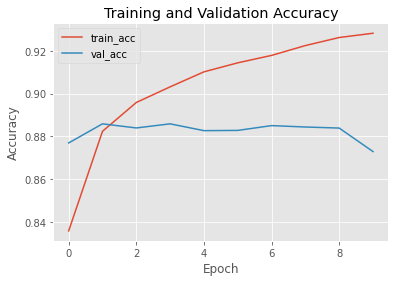

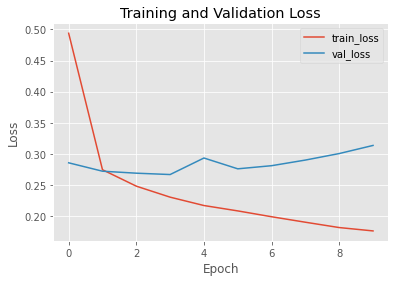

MODEL EVALUATION
571/571 [==============================] - 6s 10ms/step - loss: 0.3135 - accuracy: 0.8729

Loss = 0.31345728039741516
Test Accuracy = 0.8729063868522644
CONFUSION MATRIX


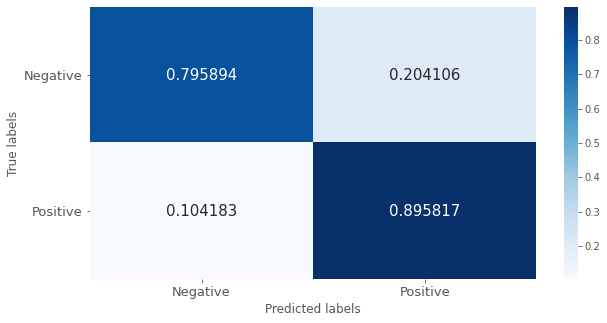

              precision    recall  f1-score   support

           0       0.69      0.80      0.74      4189
           1       0.94      0.90      0.92     14081

    accuracy                           0.87     18270
   macro avg       0.82      0.85      0.83     18270
weighted avg       0.88      0.87      0.88     18270



(<keras.engine.sequential.Sequential at 0x7f9d6a5dfb50>, 0.8729063868522644)

In [ ]:
model_train(padded_docs_train, y_train_binary, padded_docs_val, y_val_binary, vocab_size, sent_length, embedding_size=sz_vec, embedding_matrix=embedding_matrix, verbose=True, n_epochs=10, n_batch=128, layers=2, bidirectional=True, units=128, normalization=False, layer_type="LSTM",binary=True)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 81, 300)           47170200  
_________________________________________________________________
bidirectional_15 (Bidirectio (None, 81, 256)           439296    
_________________________________________________________________
batch_normalization (BatchNo (None, 81, 256)           1024      
_________________________________________________________________
bidirectional_16 (Bidirectio (None, 81, 256)           394240    
_________________________________________________________________
batch_normalization_1 (Batch (None, 81, 256)           1024      
_________________________________________________________________
flatten_8 (Flatten)          (None, 20736)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                

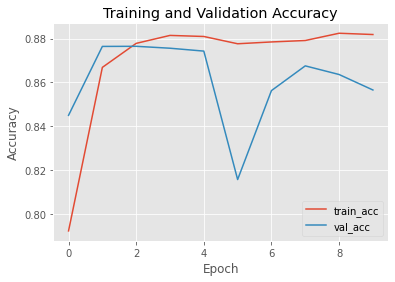

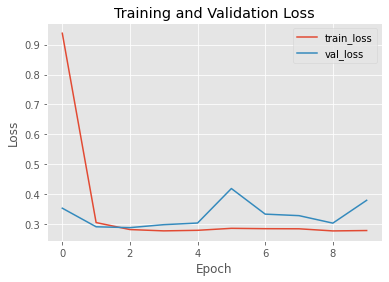

MODEL EVALUATION
571/571 [==============================] - 6s 11ms/step - loss: 0.3802 - accuracy: 0.8565

Loss = 0.38019344210624695
Test Accuracy = 0.8565407991409302
CONFUSION MATRIX


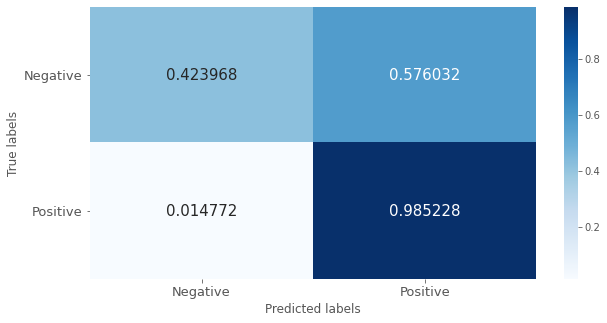

              precision    recall  f1-score   support

           0       0.90      0.42      0.58      4189
           1       0.85      0.99      0.91     14081

    accuracy                           0.86     18270
   macro avg       0.87      0.70      0.74     18270
weighted avg       0.86      0.86      0.84     18270



(<keras.engine.sequential.Sequential at 0x7f9d212b8890>, 0.8565407991409302)

In [ ]:
model_train(padded_docs_train, y_train_binary, padded_docs_val, y_val_binary, vocab_size, sent_length, embedding_size=sz_vec, embedding_matrix=embedding_matrix, verbose=True, n_epochs=10, n_batch=128, layers=2, bidirectional=True, units=128, normalization=True, layer_type="LSTM",binary=True)

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 81, 300)           47170200  
_________________________________________________________________
bidirectional_17 (Bidirectio (None, 81, 256)           439296    
_________________________________________________________________
bidirectional_18 (Bidirectio (None, 81, 256)           394240    
_________________________________________________________________
bidirectional_19 (Bidirectio (None, 81, 256)           394240    
_________________________________________________________________
flatten_9 (Flatten)          (None, 20736)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 20737     
Total params: 48,418,713
Trainable params: 1,248,513
Non-trainable params: 47,170,200
__________________________________

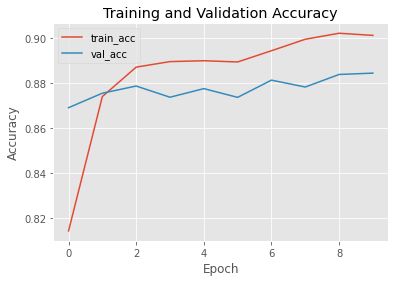

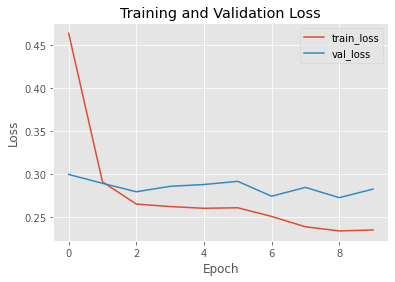

MODEL EVALUATION
571/571 [==============================] - 8s 15ms/step - loss: 0.2828 - accuracy: 0.8846

Loss = 0.2828163206577301
Test Accuracy = 0.8845648765563965
CONFUSION MATRIX


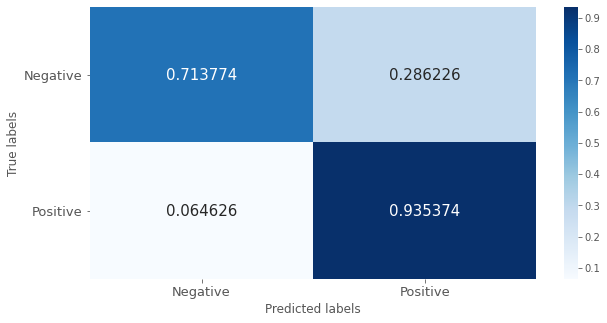

              precision    recall  f1-score   support

           0       0.77      0.71      0.74      4189
           1       0.92      0.94      0.93     14081

    accuracy                           0.88     18270
   macro avg       0.84      0.82      0.83     18270
weighted avg       0.88      0.88      0.88     18270



(<keras.engine.sequential.Sequential at 0x7f9d1e79d510>, 0.8845648765563965)

In [ ]:
model_train(padded_docs_train, y_train_binary, padded_docs_val, y_val_binary, vocab_size, sent_length, embedding_size=sz_vec, embedding_matrix=embedding_matrix, verbose=True, n_epochs=10, n_batch=128, layers=3, bidirectional=True, units=128, normalization=False, layer_type="LSTM",binary=True)

In [ ]:
params = {'dropout': 0.25}

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 81, 300)           47170200  
_________________________________________________________________
bidirectional (Bidirectional (None, 81, 256)           439296    
_________________________________________________________________
batch_normalization (BatchNo (None, 81, 256)           1024      
_________________________________________________________________
bidirectional_1 (Bidirection (None, 81, 256)           394240    
_________________________________________________________________
batch_normalization_1 (Batch (None, 81, 256)           1024      
_________________________________________________________________
bidirectional_2 (Bidirection (None, 81, 256)           394240    
_________________________________________________________________
batch_normalization_2 (Batch (None, 81, 256)           1

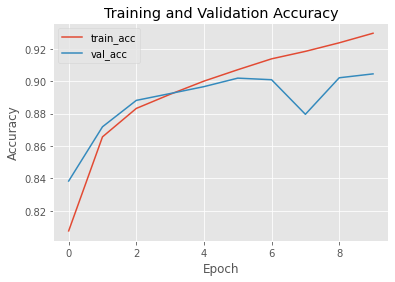

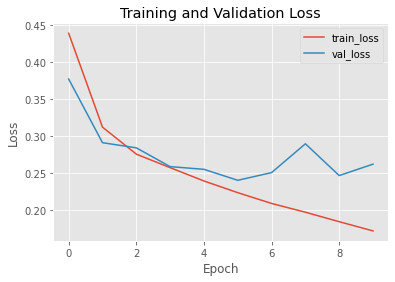

MODEL EVALUATION
571/571 [==============================] - 8s 14ms/step - loss: 0.2621 - accuracy: 0.9045

Loss = 0.26205015182495117
Test Accuracy = 0.9045429825782776
CONFUSION MATRIX


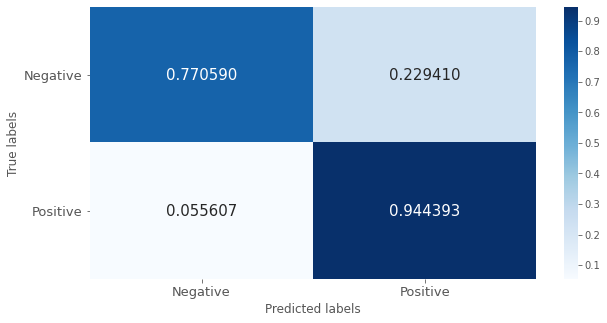

              precision    recall  f1-score   support

           0       0.80      0.77      0.79      4189
           1       0.93      0.94      0.94     14081

    accuracy                           0.90     18270
   macro avg       0.87      0.86      0.86     18270
weighted avg       0.90      0.90      0.90     18270



(<keras.engine.sequential.Sequential at 0x7f80fd676fd0>, 0.9045429825782776)

In [ ]:
model_train(padded_docs_train, y_train_binary, padded_docs_val, y_val_binary, vocab_size, sent_length, embedding_size=sz_vec, embedding_matrix=embedding_matrix, verbose=True, n_epochs=10, n_batch=128, layers=3, bidirectional=True, units=128, normalization=True, layer_type="LSTM",binary=True,learning_rate=0.001,**params)

### BERT basado en Transformers

4. Utiliza el modelo BERT basado en Transformers para clasificación de enunciados y la librería HuggingFace, obtener un modelo de clasificación de los comentarios de Amazon_Baby. Deberás usar la misma partición del documento en conjuntos de entrenamiento, validación y prueba utilizada en el ejercicio anterior.

NOTA: Debes usar la partición en su forma de texto plano, y no en
su forma embebida. Puedes apoyarte en el ejemplo para el caso de reseña de las películas IMBd que se incluye en: https://huggingface.co/transformers/custom_datasets.html#sequenceclassification-with-imdb-reviews

In [ ]:
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

In [ ]:
def batch_encode(tokenizer, texts, batch_size=256, padding='max_length', max_length=80):
    input_ids = []
    attention_mask = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        inputs = tokenizer.batch_encode_plus(batch,
                                             max_length=max_length,
                                             padding=padding,
                                             truncation=True,
                                             return_attention_mask=True,
                                             return_token_type_ids=False
                                             )
        input_ids.extend(inputs['input_ids'])
        attention_mask.extend(inputs['attention_mask'])
    return {
        'input_ids': tf.convert_to_tensor(input_ids),
        'attention_mask': tf.convert_to_tensor(attention_mask)
    }

In [ ]:
max_length = 80
n_epochs = 3
batch_size = 16

In [ ]:
train_encodings = batch_encode(tokenizer, x_train_raw.to_list(), max_length=max_length)
val_encodings = batch_encode(tokenizer, x_val_raw.to_list(), max_length=max_length)

In [ ]:
train_dataset = Dataset.from_tensor_slices((train_encodings, y_train_binary))
val_dataset = Dataset.from_tensor_slices((val_encodings, y_val_binary))

In [ ]:
model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

optimizer = Adam(learning_rate=5e-5)
loss = model.compute_loss
metrics = 'accuracy'
# optimizer = tfa.optimizers.AdamW(0.01, learning_rate=5e-5)
# loss = tf.keras.losses.CategoricalCrossentropy()
# metrics = tf.keras.metrics.CategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[metrics])
H = model.fit(train_dataset.shuffle(len(x_train_raw)).batch(batch_size), 
              epochs=n_epochs, batch_size=batch_size, 
              validation_data=val_dataset.shuffle(len(x_val_raw)).batch(batch_size))

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_transform', 'activation_13', 'vocab_layer_norm', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['dropout_19', 'classifier', 'pre_classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

Epoch 1/3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autogr

In [ ]:
print(model.summary())

Model: "tf_distil_bert_for_sequence_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
distilbert (TFDistilBertMain multiple                  66362880  
_________________________________________________________________
pre_classifier (Dense)       multiple                  590592    
_________________________________________________________________
classifier (Dense)           multiple                  1538      
_________________________________________________________________
dropout_19 (Dropout)         multiple                  0         
Total params: 66,955,010
Trainable params: 66,955,010
Non-trainable params: 0
_________________________________________________________________
None


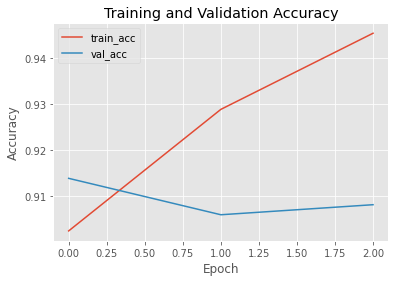

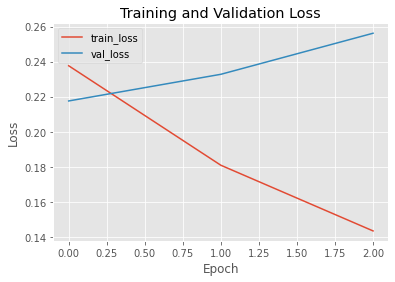

In [ ]:
plot_results(H, n_epochs)

In [ ]:
preds = model.predict(val_dataset.batch(1)).logits

In [ ]:
y_pred = tf.greater(tf.nn.softmax(preds, axis=1).numpy()[:,1], 0.5)

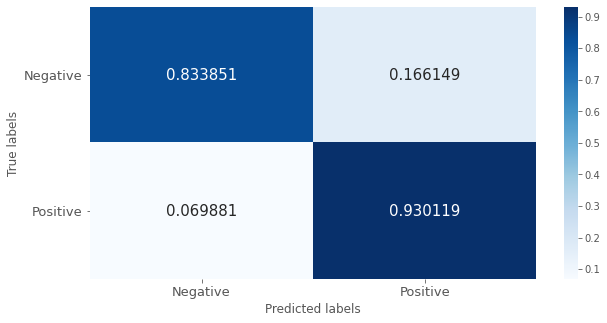

In [ ]:
labels = ["Negative", "Positive"]
cm = confusion_matrix(y_val_binary, y_pred, normalize='true')
pd_cm = pd.DataFrame(cm, index = labels, columns=labels)
plt.figure(figsize=(10,5))
g = sn.heatmap(pd_cm, annot=True, cmap="Blues", fmt="f", annot_kws={"fontsize":15})
g.set_xticklabels(g.get_xmajorticklabels(), fontsize = 13)
g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 13)
plt.yticks(rotation=0)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [ ]:
print(classification_report(y_val_binary, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.83      0.81      4189
           1       0.95      0.93      0.94     14081

    accuracy                           0.91     18270
   macro avg       0.86      0.88      0.87     18270
weighted avg       0.91      0.91      0.91     18270



### Simple Transformers

In [ ]:
!pip install simpletransformers

     |████████████████████████████████| 225kB 8.3MB/s 
     |████████████████████████████████| 51kB 9.5MB/s 
     |████████████████████████████████| 245kB 45.0MB/s 
     |████████████████████████████████| 8.2MB 47.0MB/s 
     |████████████████████████████████| 81kB 12.8MB/s 
     |████████████████████████████████| 1.2MB 43.6MB/s 
     |████████████████████████████████| 1.8MB 40.4MB/s 
     |████████████████████████████████| 122kB 59.1MB/s 
     |████████████████████████████████| 245kB 59.2MB/s 
     |████████████████████████████████| 122kB 62.4MB/s 
     |████████████████████████████████| 174kB 59.7MB/s 
     |████████████████████████████████| 4.2MB 43.8MB/s 
     |████████████████████████████████| 112kB 53.3MB/s 
     |████████████████████████████████| 81kB 13.1MB/s 
     |████████████████████████████████| 133kB 59.0MB/s 
     |████████████████████████████████| 102kB 14.5MB/s 
     |████████████████████████████████| 71kB 11.2MB/s 
     |████████████████████████████████| 122kB 56.6MB/s

In [ ]:
from simpletransformers.classification import ClassificationModel

In [ ]:
train_args={
    'num_train_epochs': 3,
    'train_batch_size': 16,
    'eval_batch_size': 64,
    'warmup_steps': 500,
    'weight_decay': 0.01,
    'logging_steps': 10,
    'learning_rate': 5e-5
}

In [ ]:
model2 = ClassificationModel('distilbert', 'distilbert-base-uncased', use_cuda=True, cuda_device=0, args=train_args)

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier

In [ ]:
train_data = list(zip(x_train_raw, y_train_binary))
test_data = list(zip(x_test_raw, y_test_binary))

train_df = pd.DataFrame(train_data)
test_df = pd.DataFrame(test_data)

In [ ]:
# Train the model
model2.train_model(train_df)

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:602: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


  0%|          | 0/146161 [00:00<?, ?it/s]

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 0 of 3:   0%|          | 0/9136 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/9136 [00:00<?, ?it/s]

Running Epoch 2 of 3:   0%|          | 0/9136 [00:00<?, ?it/s]

(27408, 0.17565893378519284)

In [ ]:
result, model_outputs, wrong_predictions = model2.eval_model(test_df, acc=accuracy_score)

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1384: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


  0%|          | 0/18271 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/286 [00:00<?, ?it/s]

In [ ]:
result

{'acc': 0.9250725192928685,
 'auprc': 0.9886245207330835,
 'auroc': 0.9671699511740726,
 'eval_loss': 0.30265271349832856,
 'fn': 672,
 'fp': 697,
 'mcc': 0.7913718484003106,
 'tn': 3602,
 'tp': 13300}

In [ ]:
predictions, raw_outputs = model2.predict(x_val_raw.to_list())

  0%|          | 0/18270 [00:00<?, ?it/s]

  0%|          | 0/286 [00:00<?, ?it/s]

In [ ]:
predictions

array([1, 0, 1, ..., 0, 1, 1])

In [ ]:
y_val_binary

array([1, 0, 0, ..., 0, 0, 1])

In [ ]:
accuracy_score(y_true=y_val_binary,y_pred=predictions)

0.9227695675971538

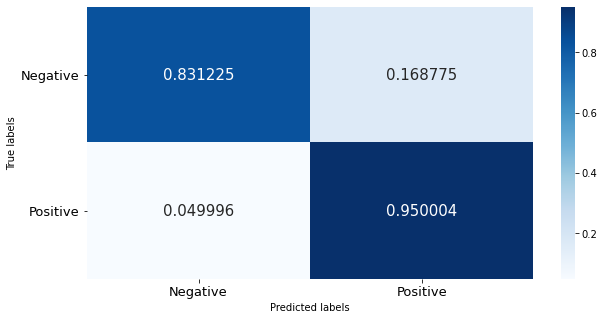

              precision    recall  f1-score   support

           0       0.83      0.83      0.83      4189
           1       0.95      0.95      0.95     14081

    accuracy                           0.92     18270
   macro avg       0.89      0.89      0.89     18270
weighted avg       0.92      0.92      0.92     18270



In [ ]:
labels = ["Negative", "Positive"]
cm = confusion_matrix(y_true=y_val_binary,y_pred=predictions,normalize='true')
pd_cm = pd.DataFrame(cm, index = labels, columns=labels)
plt.figure(figsize=(10,5))
g = sn.heatmap(pd_cm, annot=True, cmap="Blues", fmt="f", annot_kws={"fontsize":15})
g.set_xticklabels(g.get_xmajorticklabels(), fontsize = 13)
g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 13)
plt.yticks(rotation=0)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()
print(classification_report(y_true=y_val_binary,y_pred=predictions))

### Evaluacion del mejor modelo

5. Con el mejor modelo que hayas encontrado en los ejercicios 3 y 4, obtener el desempeño del conjunto de prueba. Incluye las conclusiones de los resultados obtenidos.

In [ ]:
test_encodings = batch_encode(tokenizer, x_test_raw.to_list(), max_length=max_length)

In [ ]:
test_dataset = Dataset.from_tensor_slices((test_encodings, y_test_binary))

In [ ]:
preds = model.predict(test_dataset.batch(1)).logits

In [ ]:
y_pred = tf.greater(tf.nn.softmax(preds, axis=1).numpy()[:,1], 0.5)

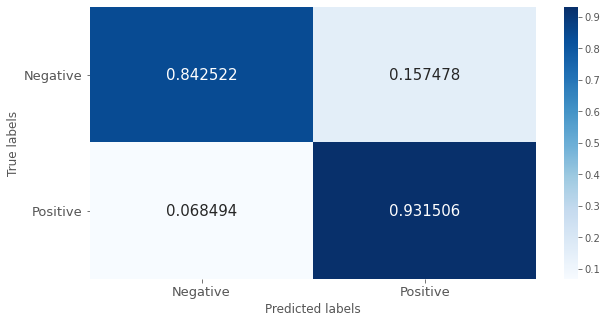

In [ ]:
labels = ["Negative", "Positive"]
cm = confusion_matrix(y_test_binary, y_pred, normalize='true')
pd_cm = pd.DataFrame(cm, index = labels, columns=labels)
plt.figure(figsize=(10,5))
g = sn.heatmap(pd_cm, annot=True, cmap="Blues", fmt="f", annot_kws={"fontsize":15})
g.set_xticklabels(g.get_xmajorticklabels(), fontsize = 13)
g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 13)
plt.yticks(rotation=0)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [ ]:
print(classification_report(y_test_binary, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.84      0.82      4299
           1       0.95      0.93      0.94     13972

    accuracy                           0.91     18271
   macro avg       0.87      0.89      0.88     18271
weighted avg       0.91      0.91      0.91     18271



### Conclusiones

El realizar un modelo de regresión que prediga la puntuación o rating específico de los comentarios fue difícil para el modelo, alcanzado precisiones de 67%. Incluso un humano tiene dificultades en determinar la puntuación con exactitud con solo leer un comentario. Debido a esto se decidió crear un dataset en el que hubiera sólo comentarios positivos (rating de 4 y 5) y negativos (1,2,3). Utilizando una red recurrente con unidades de LSTM, se alcanzó una precisión de 90%.

El mejor modelo obtenido fue BERT con fine-tunning para el entrenamiento de datos de amazon-baby.csv.

A pesar que el modelo parece tener un ligero overfitting, los resultados de 91% accuracy para el conjunto de prueba y el conjunto de validación son bastante buenos.

Utilizar la librería de simpletransformers puede beneficiar en cuanto a la simplificación del código para los parámetros del modelo, sin embargo no tenemos tanto control sobre las características del modelo.